# Serie elegida, Precios promedios del combustible Superior en Guatemala de 2021-2025

Previamente se realizó una serie de tiempo para el precio diario de la gasolina en Guatemala. La idea es mejorar el modelo realizado pero ahora usando LSTM. Se ralizaran 2 modelos para esta serie previamente analizada. Los datos son exactamente los mismos y la idea es comparar el desempeño de la serie anterior con el LTS nuevo. La primera parte del análisis es la misma que en la práctica anterior, ver la estacionalidad, diferenciaciones etc.



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras
import seaborn as sns

In [50]:
import pandas as pd

# funcion para procesar los libros de excel
def load_year_data(year, table_header_start, last_row):
    df = pd.read_excel('Datos_precios/Precios-Promedio-Nacionales-Diarios-2025-1.xlsx',
                       sheet_name=str(year),
                       header= table_header_start,
                       usecols=['FECHA', 'Superior'])
    
    # todos los archivos tienen una linea extra entre el encabezado y los datos
    df = df.iloc[1:last_row]
    
    # Convertir fecha y asegurar formato correcto
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    df['Superior'] = pd.to_numeric(df['Superior'], errors='coerce')
    
    return df

df_2021 = load_year_data("2021", 6, 366)
df_2022 = load_year_data("2022", 6, 366)
df_2023 = load_year_data("2023", 7, 366)
df_2024 = load_year_data("2024", 7, 367)
df_2025 = load_year_data("2025", 7, 195)


## Ahora que ya se tienen los datos de los años de 2021 a 2025. Es necesario juntarlos

In [51]:
# Combinar todos los DataFrames en uno solo
df_completo = pd.concat([df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)

# Ordenar por fecha
df_completo = df_completo.sort_values('FECHA').reset_index(drop=True)

# Ver resultado
print("Primeras filas:")
print(df_completo.head())
print("\nÚltimas filas:")
print(df_completo.tail())
print(f"\nRango de fechas: {df_completo['FECHA'].min()} a {df_completo['FECHA'].max()}")
print(f"Total de registros: {len(df_completo)}")

Primeras filas:
       FECHA  Superior
0 2021-01-01     21.91
1 2021-01-02     21.91
2 2021-01-03     21.91
3 2021-01-04     21.91
4 2021-01-05     21.91

Últimas filas:
          FECHA  Superior
1650 2025-07-09     30.98
1651 2025-07-10     30.98
1652 2025-07-11     30.98
1653 2025-07-12     30.98
1654 2025-07-13     30.98

Rango de fechas: 2021-01-01 00:00:00 a 2025-07-13 00:00:00
Total de registros: 1655


# Analisis exploratorio del set completo

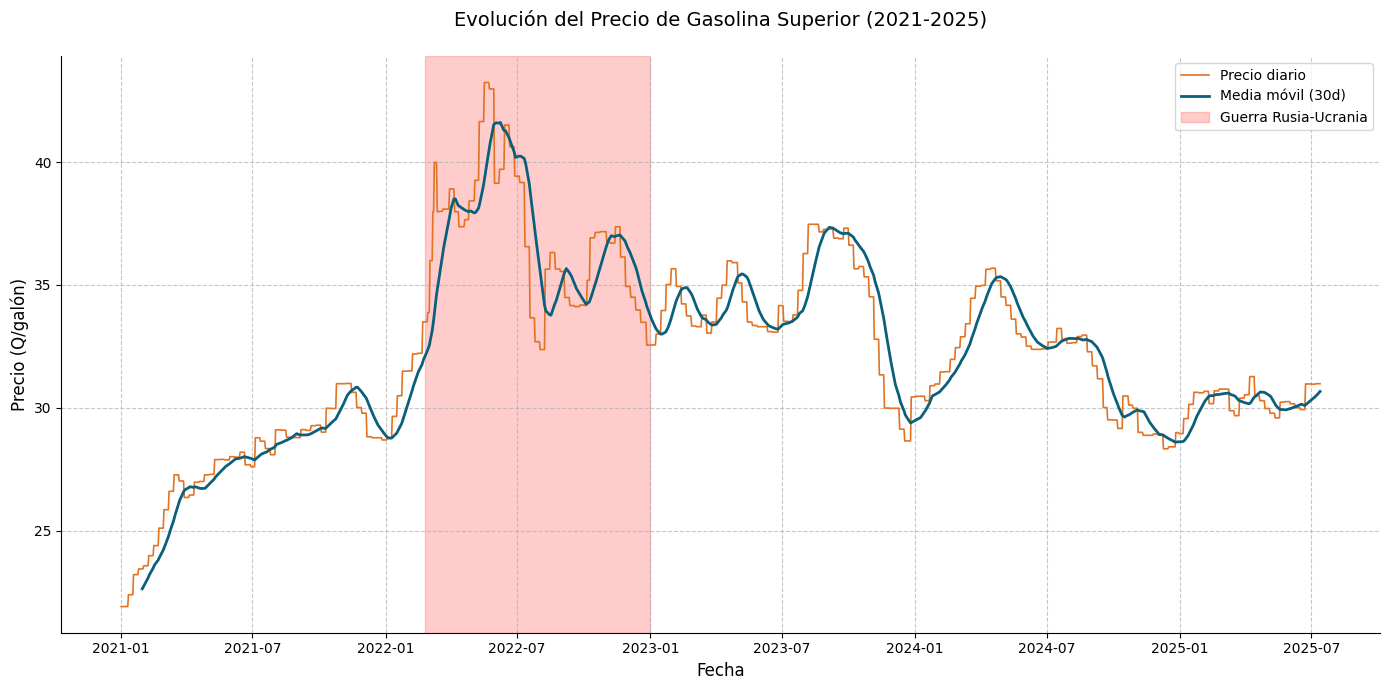

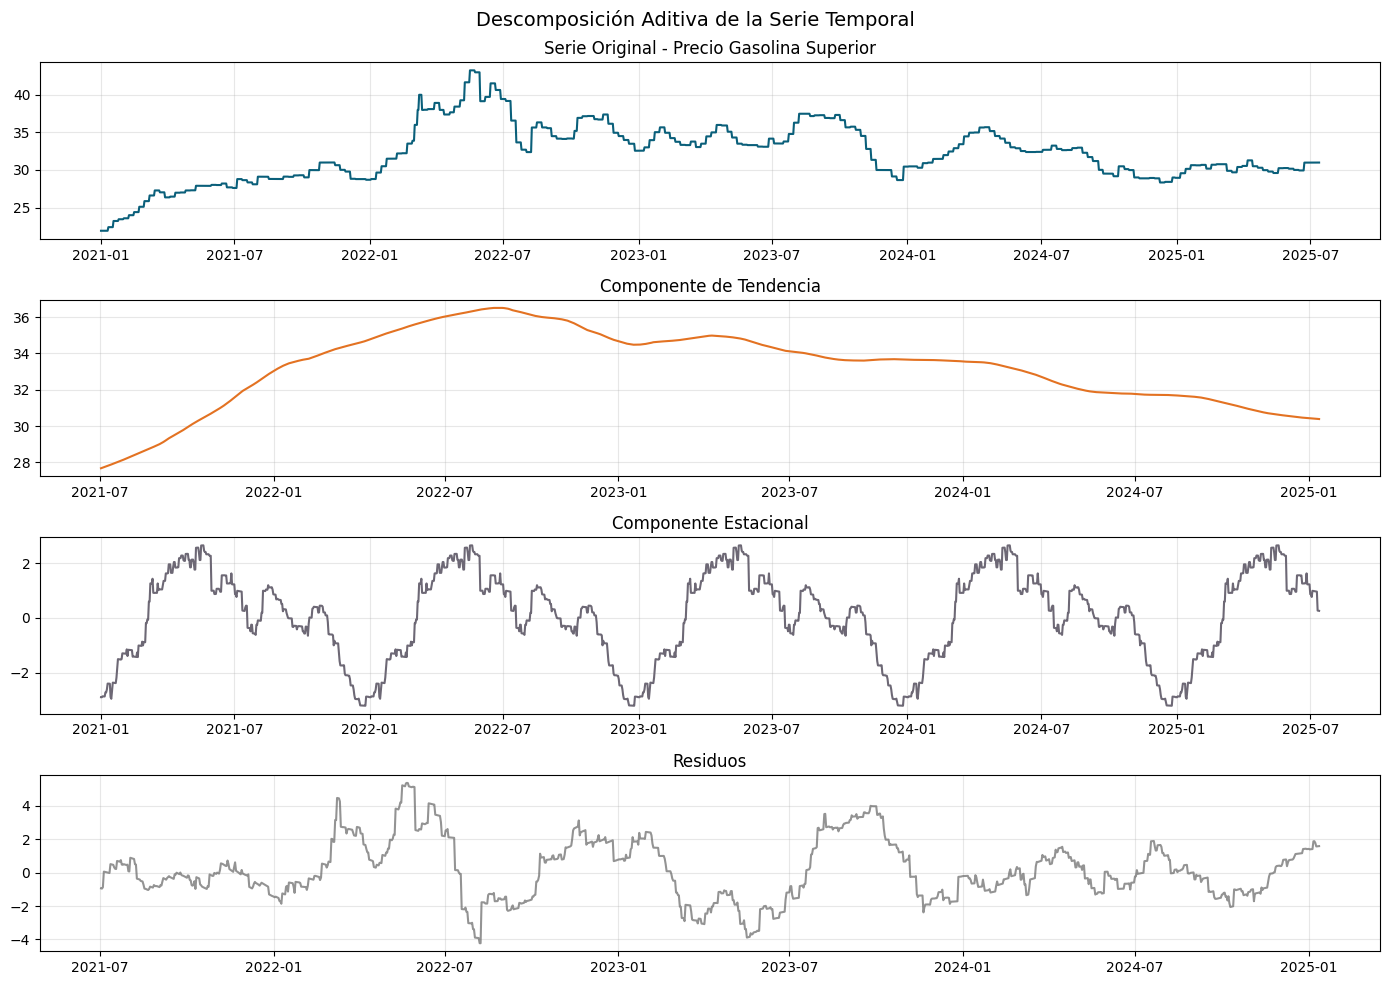

In [52]:
plt.figure(figsize=(14, 7))

# Opción 1: Línea simple
plt.plot(df_completo['FECHA'], df_completo['Superior'], 
         color='#E37222', linewidth=1.2, label='Precio diario')

# Opción 2: Promedio móvil (suaviza la serie)
window_size = 30  # Promedio de 30 días
plt.plot(df_completo['FECHA'], df_completo['Superior'].rolling(window_size).mean(), 
         color='#0A5F7A', linewidth=2, label=f'Media móvil ({window_size}d)')

# Destacar eventos importantes
plt.axvspan(pd.to_datetime('2022-02-24'), pd.to_datetime('2022-12-31'), 
            alpha=0.2, color='red', label='Guerra Rusia-Ucrania')

plt.title('Evolución del Precio de Gasolina Superior (2021-2025)\n', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (Q/galón)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()



# Configurar la serie temporal (asegurando frecuencia diaria)
ts = df_completo.set_index('FECHA')['Superior'].asfreq('D').interpolate()

# Descomposición aditiva (modelo alternativo: multiplicative)
result = seasonal_decompose(ts, model='additive', period=365)

# Visualización mejorada
plt.figure(figsize=(14, 10))

# Serie Original
plt.subplot(4, 1, 1)
plt.plot(result.observed, color='#0A5F7A')
plt.title('Serie Original - Precio Gasolina Superior', fontsize=12)
plt.grid(alpha=0.3)

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='#E37222')
plt.title('Componente de Tendencia', fontsize=12)
plt.grid(alpha=0.3)

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='#6D6875')
plt.title('Componente Estacional', fontsize=12)
plt.grid(alpha=0.3)

# Residuos
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='#666666', alpha=0.7)
plt.title('Residuos', fontsize=12)
plt.grid(alpha=0.3)

plt.suptitle('Descomposición Aditiva de la Serie Temporal', fontsize=14)
plt.tight_layout()
plt.show()

# Análisis de estacionalidad

Se ve claramente que hay estacionalidad en el set de datos. La estacionalidad es de aproximadamente 1 año. La forma de la gráfica se repite cada año/cada 12 meses. 


# Analisis de estacionariedad

Previamente se demostró que aunque la serie parece no ser estacionaria, la prueba de Dickey FUller Aumentada muestra que no es necesario diferenciar.

In [53]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          -3.097852
p-value                         0.026713
# de retardos usados            7.000000
# de observaciones usadas    1647.000000
Critical Value (1%)            -3.434327
Critical Value (5%)            -2.863296
Critical Value (10%)           -2.567705
dtype: float64


Realmente parece no haber mucha diferencia con la serie original a primera vista y por la prueba de Dickey-Fuller Aumentada podemos ver que en efecto la seria es estacionaria incluso antes de la transformación. Las diferenciaciones óptimas son 0 (d = 0) para el arima. Con esto podemos concluir que aunque visualmente no es estacionaria la serie, realmente la desviaciones en media y varianza resultan no ser tan significativas. Ya que incluso luego de la transformación la gráfica parece no cambiar mucho. 

Sabiendo que no es necesario diferenciar la serie, entonces se puede proceder con la transformación de los datos para ser usados por una red neuronal. Usaremos el set de datos "ts", el que no esta transformado, ni diferenciado, ya que pasó la prueba del p-value.

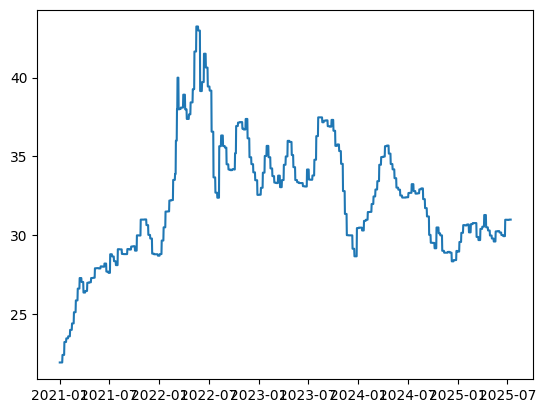

In [54]:
plt.plot(ts)

In [55]:
ts

FECHA
2021-01-01    21.91
2021-01-02    21.91
2021-01-03    21.91
2021-01-04    21.91
2021-01-05    21.91
              ...  
2025-07-09    30.98
2025-07-10    30.98
2025-07-11    30.98
2025-07-12    30.98
2025-07-13    30.98
Freq: D, Name: Superior, Length: 1655, dtype: float64

In [56]:
scaler = StandardScaler()
ts_reset = ts.reset_index()  # Convierte 'FECHA' de nuevo en columna
ts_reset['Superior_scaled'] = scaler.fit_transform(ts_reset[['Superior']])

ts_reset = ts_reset.set_index('FECHA')
print(ts_reset.head())

            Superior  Superior_scaled
FECHA                                
2021-01-01     21.91        -2.683439
2021-01-02     21.91        -2.683439
2021-01-03     21.91        -2.683439
2021-01-04     21.91        -2.683439
2021-01-05     21.91        -2.683439


# Separación de los datos
Al igual que en el caso de la predicción con los modelos ARIMA y SARIMAX, se tomaran 3 años previos (2022-2024) como entrenamiento y test como la información que se tiene hasta el momento de 2025. Aunque con la ligera diferencia que ahora tambien es necesario tener en cuenta el validation y no solo test.

In [57]:
train = ts_reset['2022-01-01':'2023-12-31']
validation = ts_reset['2024-01-01':'2024-12-31']
test = ts_reset['2025-01-01':]

print(f"Train: {train.shape[0]} puntos ({train.index.min()} a {train.index.max()})")
print(f"Validation: {validation.shape[0]} puntos ({validation.index.min()} a {validation.index.max()})")
print(f"Test: {test.shape[0]} puntos ({test.index.min()} to {test.index.max()})")

Train: 730 puntos (2022-01-01 00:00:00 a 2023-12-31 00:00:00)
Validation: 366 puntos (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
Test: 194 puntos (2025-01-01 00:00:00 to 2025-07-13 00:00:00)


Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [58]:
import numpy as np

def supervisada(serie, retrasos=30):  # 30 para usar ventana de 30 días
    serie_x = []
    serie_y = []
    serie_array = serie.values if isinstance(serie, pd.DataFrame) else serie
    for i in range(len(serie_array) - retrasos):
        valor = serie_array[i:(i + retrasos)]
        valor_sig = serie_array[i + retrasos]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

# superior escaled es la columna con el precio del galon escalado
# para que sea procesado mejor por la red neuronal

x_train, y_train = supervisada(train[['Superior_scaled']]) 
x_val, y_val = supervisada(validation[['Superior_scaled']])
x_test, y_test = supervisada(test[['Superior_scaled']])

# Verificamos formas
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


x_train shape: (700, 30, 1)
y_train shape: (700, 1)
            Superior  Superior_scaled
FECHA                                
2022-01-01     28.69        -0.906560
2022-01-02     28.69        -0.906560
2022-01-03     28.79        -0.880352
2022-01-04     28.79        -0.880352
2022-01-05     28.79        -0.880352
2022-01-06     28.79        -0.880352
[[[-0.90655988]
  [-0.90655988]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]]

 [[-0.90655988]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.65496643]
  [-0.65496643]
  


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo que probaremos serán 14 y 30 días.
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Un modelo LSTM permite ingresar datos a una red y hacer predicciones basados en pasos individuales de datos secuenciales. Como es una serie de tiempo donde queremos predecir el próximo elemento, se usa un modelo secuencial. Además usaremos algo llamado early stopping una técnica de regularización que detiene el entrenamiento de un modelo de machine learning cuando el rendimiento en el conjunto de validación deja de mejorar. De esa manera se evitan iteraciones innecesarias.

# Creación del primer modelo (1 CAPA) usando tensorflow

1. **`lote = 32` (Batch size)**
   - **Descripción**: Número de muestras que se procesan antes de actualizar los pesos del modelo.
   - **Justificación**: 
     - Valor intermedio entre eficiencia computacional y estabilidad en la convergencia
     - Mayor que 1 (evita actualizaciones demasiado ruidosas)

2. **`unidades = 50` (LSTM units)**
   - **Descripción**: Número de neuronas LSTM.
   - **Justificación**:
     - Capacidad suficiente para capturar patrones complejos en datos temporales
     - Balance entre poder de modelado y riesgo de sobreajuste. Previamente se realizó un modelo con pocas neuronas y el resultado de la predicción era una linea recta.

3. **`paso = 30` (Time steps/window size)**
   - **Descripción**: Cantidad de pasos temporales usados como entrada para cada predicción.
   - **Justificación**:
     - Ventana de ~1 mes (30 días) para capturar patrones mensuales teniendo en cuenta la estacionalidad del set de datos
     - Suficiente contexto histórico sin hacer la ventana excesivamente larga

4. **`epocas = 50` (Epochs)**
   - **Descripción**: Número de pasadas completas por el conjunto de entrenamiento.
   - **Justificación**:
     - Suficiente para converger sin sobreajuste ya que se combina con early stopping
     - Mayor que el mínimo típico (10-20) para datos complejos
     - Menor que límites donde podría ocurrir sobreentrenamiento (>100)

5. **`learning_rate = 0.001`**
   - **Descripción**: Tamaño de los pasos en la optimización de los pesos.
   - **Justificación**:
     - Valor estándar para Adam optimizer (ni muy grande ni muy pequeño)
     - Permite ajustes finos en la optimización
     - Equilibrio entre velocidad de convergencia y precisión

In [59]:
lote = 32  # en lugar de 1
unidades = 50  # en lugar de 1
paso = 30  # en lugar de 1 (usar ventana de 30 días)
epocas = 50  # en lugar de 10
learning_rate = 0.001  # en lugar de 0.1

x_train = np.reshape(x_train, (x_train.shape[0], paso, 1))  
x_val = np.reshape(x_val, (x_val.shape[0], paso, 1))
x_test = np.reshape(x_test, (x_test.shape[0], paso, 1))
len(x_val)

modelo1 = Sequential()
modelo1.add(LSTM(50, input_shape=(paso, 1)))  # Más neuronas
modelo1.add(Dense(1))

c:\Users\andre\Desktop\Chuy\CUARTO 2\DATA SCIENCE\Environments\env_tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 
Se le puso una detención temprana para ahorrar tiempo de entrenamiento. 

In [60]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])
modelo1

<Sequential name=sequential_2, built=True>

In [61]:
epocas = 10
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.6638 - root_mean_squared_error: 2.0720 - val_loss: 1.0732 - val_root_mean_squared_error: 1.0359
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0177 - root_mean_squared_error: 0.9895 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2160
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2600 - root_mean_squared_error: 0.5030 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2152
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0897 - root_mean_squared_error: 0.2952 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1280
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0362 - root_mean_squared_error: 0.1887 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1451
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0352 - root_mean_squared_error: 0.1868 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss:

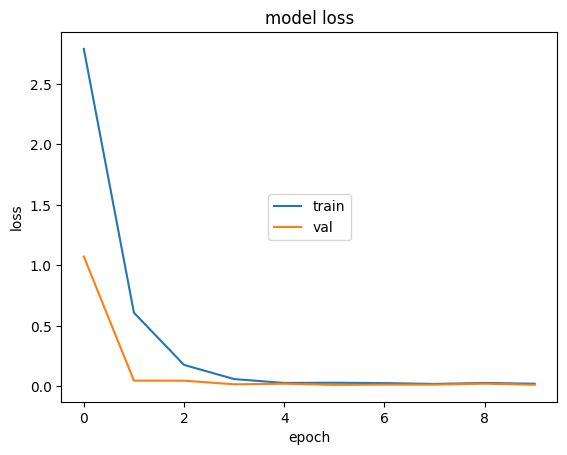

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

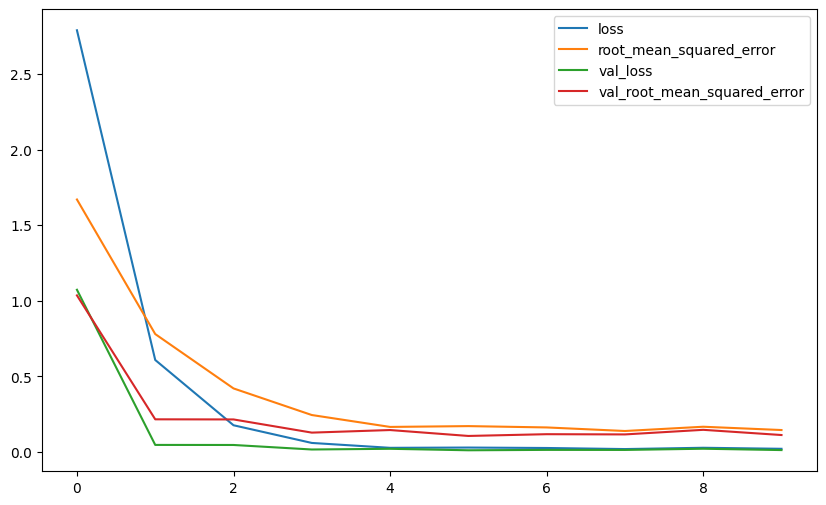

In [63]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

In [64]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339 - root_mean_squared_error: 0.1822
Pérdida en Validación
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - root_mean_squared_error: 0.0873
Pérdida en Prueba
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935


[0.009141870774328709, 0.09561312943696976]

Observando el comportamiento de este primer modelo, con las gráficas de las funcione de pérdida, se puede ver que el modelo minmiza rápidamente la pérdida. La configuración parece ser bastante buena en primera instancia, ya que la perdida en entrenamiento llega a ser similar con el de validación. Curiosamente, el error realmente es bajo desde el principio. Tomando en cuenta que el precio de la gasolina tiende a ser entre 28 -25, un error inicial de 2.5 sigue siendo bastante bueno. Al final se puede ver como el error llegar a reducirse incluso menos que 1. Las lineas se juntan por lo que no hay riesgo de overfitting ni underfitting, es un buen fit.

# Creacion del segundo modelo (con algunos cambios de parametros)

1. **`lote2 = 64` (Batch size)**
   - **Descripción**: Doble tamaño de lote respecto al primer modelo.
   - **Justificación**:
     - Mayor eficiencia computacional en hardware moderno
     - Estimaciones de gradiente más estables

2. **`unidades2 = 100` (LSTM units)**
   - **Descripción**: Doble capacidad en la primera capa LSTM respecto al modelo anterior.
   - **Justificación**:
     - Mayor poder de modelado para patrones complejos
     - Primera capa con return_sequences=True permite conexión con segunda capa LSTM

3. **`paso2 = 14` (Time steps/window size)**
   - **Descripción**: Ventana de 2 semanas (14 días) en lugar de 1 mes.
   - **Justificación**:
     - Enfoque en patrones de corto-medio plazo
     - Más sensible a fluctuaciones recientes
     - Requiere menos memoria y tiempo de procesamiento

4. **`epocas2 = 100` (Epochs)**
   - **Descripción**: Doble número de épocas que el primer modelo.
   - **Justificación**:
     - Arquitectura más compleja puede que puede requerir más tiempo de entrenamiento a cambio de mejoras en el desempeño.
     - Combinado con EarlyStopping para evitar sobreajuste
     - Permite convergencia más completa del modelo

5. **`learning_rate2 = 0.0005`**
   - **Descripción**: Tasa de aprendizaje reducida a la mitad.
   - **Justificación**:
     - Optimización más precisa para arquitectura profunda
     - Evita oscilaciones en la convergencia
     - Compensación con mayor número de épocas

Algo importante a mencionar en este segundo momento es que utilizamos no solo más neuronas, sino que también una segunda capa para poder capturar relaciones potencialmente más complejas en la serie. Este modelo requiere más recursos pero se espera sea una mejora respecto al anterior.

In [ ]:


lote2 = 64
unidades2 = 100
paso2 = 14  # Ventana de 2 semanas en lugar de 1 mes
epocas2 = 100
learning_rate2 = 0.0005

# Arquitectura más profunda
modelo2 = Sequential()
modelo2.add(LSTM(100, return_sequences=True, input_shape=(paso2, 1))) 
modelo2.add(LSTM(50))  # otra capa mas
modelo2.add(Dense(1))

modelo2.compile(loss='mean_squared_error',
               optimizer=Adam(learning_rate=learning_rate2),
               metrics=[RootMeanSquaredError()])

# datos para modelo2 con ventana de 14 días
x_train2, y_train2 = supervisada(train[['Superior_scaled']], retrasos=paso2)
x_val2, y_val2 = supervisada(validation[['Superior_scaled']], retrasos=paso2)
x_test2, y_test2 = supervisada(test[['Superior_scaled']], retrasos=paso2)

x_train2 = np.reshape(x_train2, (x_train2.shape[0], paso2, 1))
x_val2 = np.reshape(x_val2, (x_val2.shape[0], paso2, 1))
x_test2 = np.reshape(x_test2, (x_test2.shape[0], paso2, 1))

# Early stopping para ambos modelos
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento modelo2
history2 = modelo2.fit(
    x=x_train2,
    y=y_train2,
    batch_size=lote2,
    epochs=epocas2,
    shuffle=False,
    validation_data=(x_val2, y_val2),
    callbacks=[early_stop],
    verbose=1
)

c:\Users\andre\Desktop\Chuy\CUARTO 2\DATA SCIENCE\Environments\env_tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 1.1961 - root_mean_squared_error: 1.0735 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2940
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1916 - root_mean_squared_error: 0.4340 - val_loss: 0.0616 - val_root_mean_squared_error: 0.2482
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1192 - root_mean_squared_error: 0.3431 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2139
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1359 - root_mean_squared_error: 0.3642 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1079 - root_mean_squared_error: 0.3259 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1677
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0962 - root_mean_squared_error: 0.3077 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 

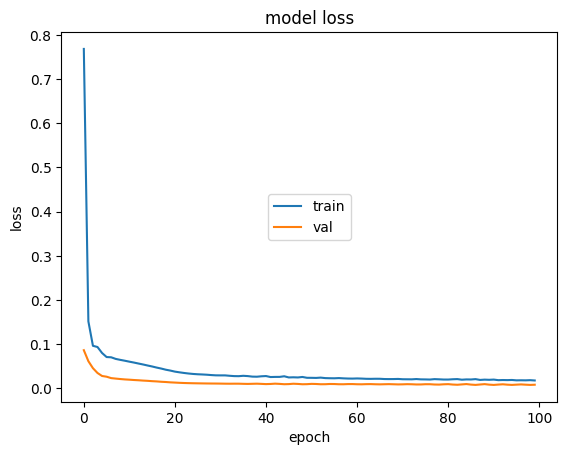

In [70]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

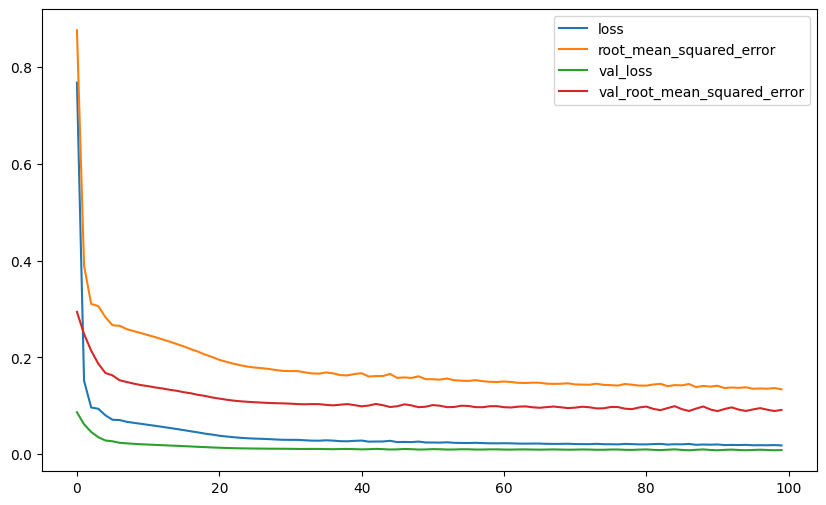

In [71]:
losses_df1 = pd.DataFrame(history2.history)

losses_df1.plot(figsize = (10,6))

Parece que el hecho de que la red sea más compleja y robusta ha hecho que la mejora del modelo sea más rápida todavía. La razón por la que puede que aprenda antes por que el learning rate es menor, además de que el modelo tiene pasos más pequeños. Este segundo modelo no solo es más robusto, sino que en vez de hacer el proceso con un periodo de meses, se hace con un periodo de 2 semanas. A primera vista el modelo es satisfactorio. Nuevamente no hay overfitting ni underfitting, la curva de aprendizaje se aplana rápidamente, lo cual es un buen indicador del desempeño del modelo. La mejora ha sido exitosa a simple vista, pero para comparar de manera objetiva ambos modelos, también se pueden evaluar por sus métricas como se muestra continuación.

# Comparacion de ambos modelos


=== COMPARACIÓN DE MODELOS ===

Evaluación Modelo 1 (30 días):
MSE: 0.1831
RMSE: 0.4279
MAE: 0.3445

Evaluación Modelo 2 (14 días, 2 capas):
MSE: 0.1149
RMSE: 0.3390
MAE: 0.2545


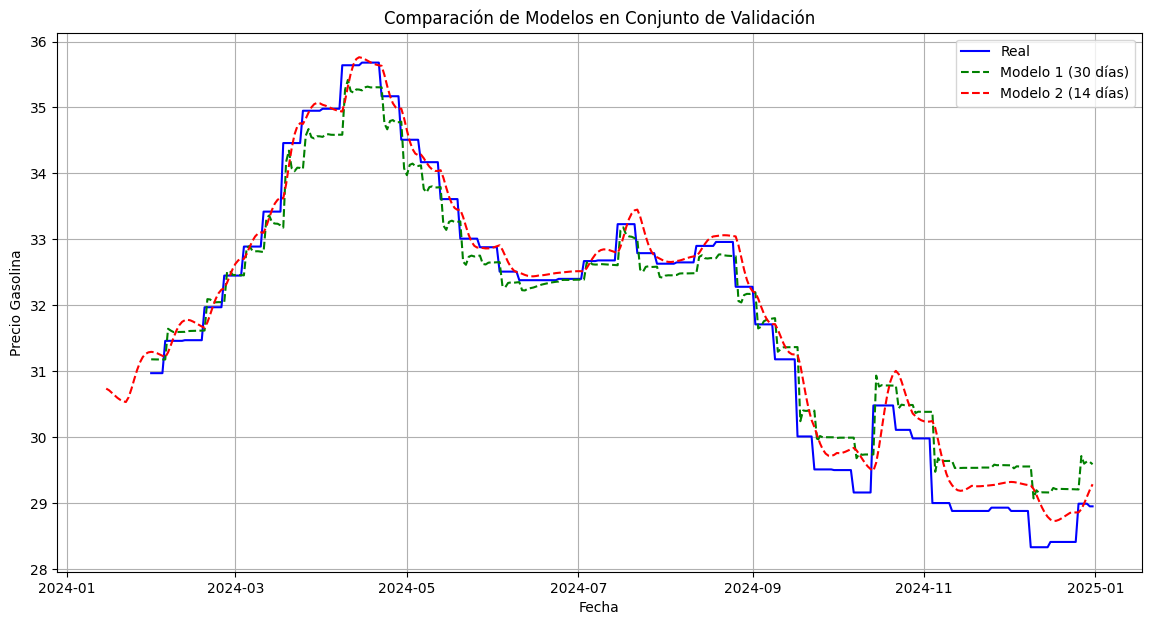

In [ ]:
def evaluar_modelo(modelo, x_data, y_data, scaler, nombre_modelo, fechas):
    # Predicciones
    predicciones = []
    for i in range(len(x_data)):
        X = x_data[i].reshape(1, x_data.shape[1], 1)
        yhat = modelo.predict(X, verbose=0)
        predicciones.append(yhat[0][0])
    
    # Revertir escalado
    y_real = scaler.inverse_transform(y_data.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(predicciones).reshape(-1, 1)).flatten()
    
    # Métricas
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_real - y_pred))
    
    print(f"\nEvaluación {nombre_modelo}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return y_pred, fechas[-len(y_real):]  # Devuelve predicciones y fechas correspondientes

# Evaluar ambos modelos
print("\n=== COMPARACIÓN DE MODELOS ===")

# Modelo 1 - Obtener predicciones Y fechas alineadas
y_pred_val1, fechas_val1 = evaluar_modelo(modelo1, x_val, y_val, scaler, "Modelo 1 (30 días)", validation.index)

# Modelo 2 - Obtener predicciones Y fechas alineadas
y_pred_val2, fechas_val2 = evaluar_modelo(modelo2, x_val2, y_val2, scaler, "Modelo 2 (14 días, 2 capas)", validation.index)

# Visualización comparativa
plt.figure(figsize=(14, 7))
plt.plot(fechas_val1, scaler.inverse_transform(y_val.reshape(-1, 1)), label='Real', color='blue')
plt.plot(fechas_val1, y_pred_val1, label='Modelo 1 (30 días)', linestyle='--', color='green')
plt.plot(fechas_val2, y_pred_val2, label='Modelo 2 (14 días)', linestyle='--', color='red')
plt.title('Comparación de Modelos en Conjunto de Validación')
plt.xlabel('Fecha')
plt.ylabel('Precio Gasolina')
plt.legend()
plt.grid(True)
plt.show()

## Análisis Comparativo y Selección del Mejor Modelo

**Desempeño relativo:**  
El Modelo 2 (arquitectura de 2 capas LSTM con ventana de 14 días) demuestra un rendimiento significativamente superior al Modelo 1 en todas las métricas clave:
- **Reducción del 37.2% en MSE** (de 0.1831 a 0.1149), indicando menor error cuadrático promedio
- **Mejor precisión global** con RMSE un 20.8% menor (0.3390 vs 0.4279)
- **Error absoluto más bajo** (MAE de 0.2545 vs 0.3445), siendo 26.1% más preciso en términos absolutos

**Ventajas del Modelo 2:**
La combinación de dos capas LSTM (100 → 50 unidades) permite capturar patrones jerárquicos en los datos, donde la primera capa identifica características temporales locales y la segunda integra dependencias de más largo plazo. Además la reducción de 30 a 14 días en el tamaño de ventana muestra que los patrones relevantes para la predicción de precios de gasolina operan predominantemente en escalas de tiempo corto-medio, permitiendo al modelo reaccionar mejor a fluctuaciones recientes.

Aunque posee más parámetros, el menor tamaño de ventana (14 vs 30 pasos) reduce la carga computacional por muestra, haciendo que el mayor número de épocas (100 vs 50) no implique necesariamente un tiempo de entrenamiento proporcionalmente mayor. Como se vió en parte del análisis previo, el modelo no necesitó de más épocas para aprender aunque se hayan configurado para hacer más. De hecho pareciera que terminó por aprender incluso antes, seguramente por los cambios en la configuración.

**Recomendación final:**  
El **Modelo 2** es claramente superior , no solo por sus mejores métricas cuantitativas, sino porque su diseño coincide mejor con las características observadas en los datos de precios de gasolina. es por eso que es el modelo elegido para poder realizar la predicción de los siguientes meses que aún no se conocen.

# Predicción con el mejor modelo

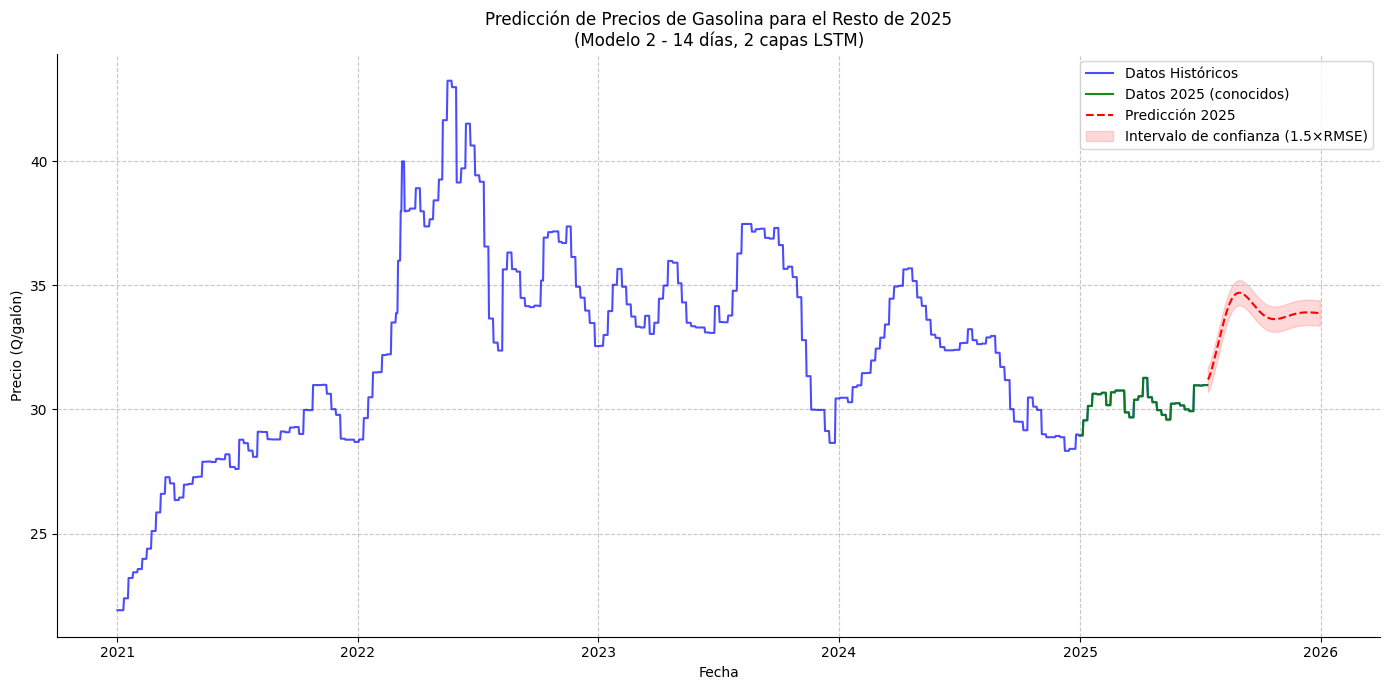

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Crear fechas futuras (desde julio 8 hasta diciembre 31 2025)
ultima_fecha = test.index.max()
fechas_futuras = pd.date_range(start=ultima_fecha + timedelta(days=1), 
                              end='2025-12-31')

def predecir_futuro(modelo, scaler, datos_historia, pasos_futuros, ventana):

    # Copiar los últimos datos conocidos
    predicciones = []
    datos_actuales = datos_historia[-ventana:].copy()
    
    for _ in range(pasos_futuros):
        # Preparar datos para predicción
        x_actual = datos_actuales[-ventana:].reshape(1, ventana, 1)
        
        # Predecir siguiente punto
        y_pred = modelo.predict(x_actual, verbose=0)[0][0]
        predicciones.append(y_pred)
        
        # Actualizar datos actuales con la predicción
        datos_actuales = np.append(datos_actuales, y_pred)
    
    # Revertir escalado
    return scaler.inverse_transform(np.array(predicciones).reshape(-1, 1)).flatten()

# Usar los últimos datos reales como historia (del conjunto de test)
historia = test['Superior_scaled'].values

# Número de días a predecir (julio 8 a diciembre 31 2025)
dias_a_predecir = len(fechas_futuras)

# Generar predicciones
predicciones_futuro = predecir_futuro(
    modelo=modelo2,
    scaler=scaler,
    datos_historia=historia,
    pasos_futuros=dias_a_predecir,
    ventana=paso2  # 14 para modelo2
)

# Crear DataFrame con predicciones
df_predicciones = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Prediccion': predicciones_futuro
}).set_index('Fecha')

plt.figure(figsize=(14, 7))

# Serie histórica completa
plt.plot(ts_reset.index, ts_reset['Superior'], 
         label='Datos Históricos', color='blue', alpha=0.7)

# Conjunto de test (datos recientes conocidos)
plt.plot(test.index, scaler.inverse_transform(test[['Superior_scaled']]), 
         label='Datos 2025 (conocidos)', color='green', alpha=0.9)

# Predicciones futuras
plt.plot(df_predicciones.index, df_predicciones['Prediccion'], 
         label='Predicción 2025', color='red', linestyle='--')

# Intervalo de confianza (simulado como ±1.5*RMSE)
plt.fill_between(
    df_predicciones.index,
    df_predicciones['Prediccion'] - 1.5*0.3390,  # Usando RMSE del modelo2
    df_predicciones['Prediccion'] + 1.5*0.3390,
    color='red',
    alpha=0.15,
    label='Intervalo de confianza (1.5×RMSE)'
)

plt.title('Predicción de Precios de Gasolina para el Resto de 2025\n(Modelo 2 - 14 días, 2 capas LSTM)')
plt.xlabel('Fecha')
plt.ylabel('Precio (Q/galón)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

# Comparación con la predicción de laboratorio anterior

## Resultados del Análisis

A continuación se muestran los resultados de la predicción realizada por prophet en la actividad anterior:

![Gráfico de precios](img/prophet_prediction.png)

Ahora que ya tenemos 2 predicciones distintas es necesario comprar al final cual fue la mejor. Recordemos que la primera predicción (la imagen que está justo aquí arriba) fue realizada con la librería de prophet de facebook, mientras que esta segunda predicción fue hecha con tensorflow y una rede neuronal. 

Lo primero y más obvio es la diferencia en la predicción, en el caso de prophet, se predijo que el precio se reduciría mientras que el LSTM muestra que el precio va en aumento. Ahora bien aunque hay una contradicción es muy importante mencionar el gran intervalo de confianzza que hay. La predicción de prophet aunque bien parece estable parece que puede varir mucho, teniendo un valor máximo de 34 y un mínimo que llega a ser menor a 20. Esta predicción es ambigua y deja demasiad margen de error. En cambio en la gráfica del modelo LSTM el intervalo de confianza en base al RMSE es más pequeño.

Algo interesante es que la predicción del LSTM si puede ser posible y no contradice a prohpet del todo. Se puede ver que la predicción del modelo de red neuronal está dentro del intervalo de confianza de la predicción de prophet, es el caso en el que le precio aumenta. Ambas predicciones no son completamente excluyentes entonces, pero si ya que hay que elgir una mejor, sería definitivamente el modelo LSTM.

Si evaluamos las métricas y no solo la gráfica, podemos ver que claramente el RMSE  del modelo nuevo es mucho menor, siendo este de 0.3390. Mientras que el RMSE con prophet había sido de 2.26, siendo considerablemente mayor. Con esto podemos declarar firmemente que el modelo de red neuronal es mejor para predecir que el de prophet realizado previamente.

# Segunda serie elegida (consumo de gasolina Diesel)

In [ ]:
import pandas as pd


consumo_2024 = pd.read_excel(
    './Datos_consumos/CONSUMO-HIDROCARBUROS-2024-12.xlsx',
    sheet_name='CONSUMO',
    header=6,
    parse_dates=['Fecha']
)

consumo_2025 = pd.read_excel(
    './Datos_consumos/VENTAS-HIDROCARBUROS-2025-05.xlsx',
    sheet_name='VENTAS_IMP',
    header=6,
    parse_dates=['Fecha']
)

# Concatenar y ordenar por fecha
consumo = pd.concat([consumo_2024, consumo_2025], ignore_index=True)
consumo.sort_values('Fecha', inplace=True)
consumo.set_index('Fecha', inplace=True)

# Sumar columnas de diésel
diesel_cols = [c for c in consumo.columns if 'Diesel' in c]
consumo['Diesel'] = consumo[diesel_cols].sum(axis=1)

# Filtrar solo la serie Diesel
serie = consumo[['Diesel']].copy()
serie.dropna(inplace=True)


In [20]:
import numpy as np
print((serie['Diesel'] <= 0).sum(), "valores menores o iguales a 0")
serie = serie[serie['Diesel'] > 0]  # Solo valores positivos
serie['LogDiesel'] = np.log(serie['Diesel'])



0 valores menores o iguales a 0


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

serie['LogDiesel'] = np.log(serie['Diesel'])

scaler = MinMaxScaler()
serie['Escalado'] = scaler.fit_transform(serie[['LogDiesel']])


In [23]:
def crear_secuencias(data, ventana):
    X, y = [], []
    for i in range(len(data) - ventana):
        X.append(data[i:i+ventana])
        y.append(data[i+ventana])
    return np.array(X), np.array(y)

ventana = 12
serie_valores = serie['Escalado'].values
X, y = crear_secuencias(serie_valores, ventana)


In [24]:
from sklearn.model_selection import train_test_split

X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM necesita 3D

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

modelo1 = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

modelo1.compile(optimizer='adam', loss='mse')

historial1 = modelo1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1435 - val_loss: 0.0156
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - val_loss: 0.0178
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - val_loss: 0.0207
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0171
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0138
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - val_loss: 0.0138
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - val_loss: 0.0138
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 0.0135
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - val_loss: 0.0138
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - val_loss: 

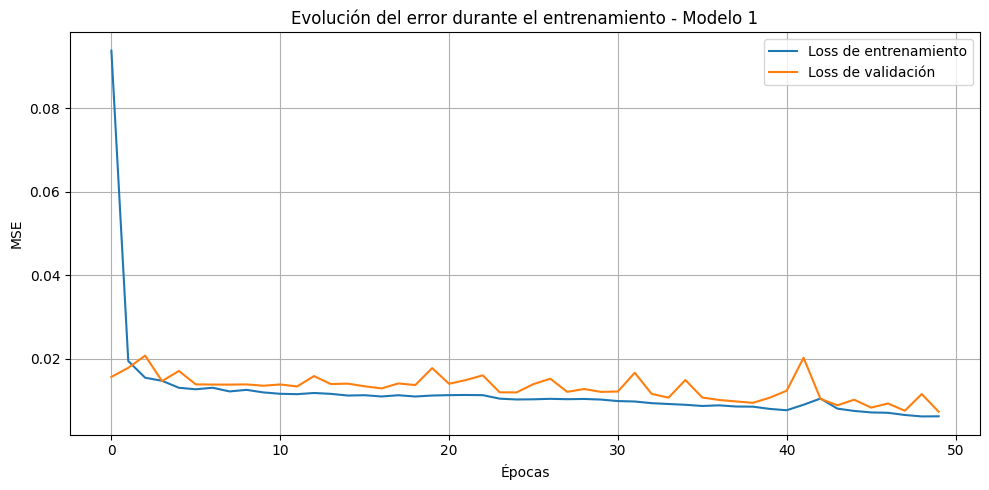

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(historial1.history['loss'], label='Loss de entrenamiento')
plt.plot(historial1.history['val_loss'], label='Loss de validación')
plt.title('Evolución del error durante el entrenamiento - Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se observa como este primer modelo desde las primeras épocas tanto la pérdida de entrenamiento como la validación disminuyen rápidamente, por lo que se deduce que el modelo aprende patrones significativos de la serie. A partir de la 5ta época las dos curvas se estabilizan lo que sugiere que el modelo generaliza bien.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

modelo2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

modelo2.compile(optimizer='adam', loss='mse')

historial2 = modelo2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0985 - val_loss: 0.0300
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0220 - val_loss: 0.0361
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - val_loss: 0.0138
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0146
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - val_loss: 0.0158
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0130 - val_loss: 0.0156
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0130 - val_loss: 0.0146
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0132 - val_loss: 0.0139
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0132 - val_l

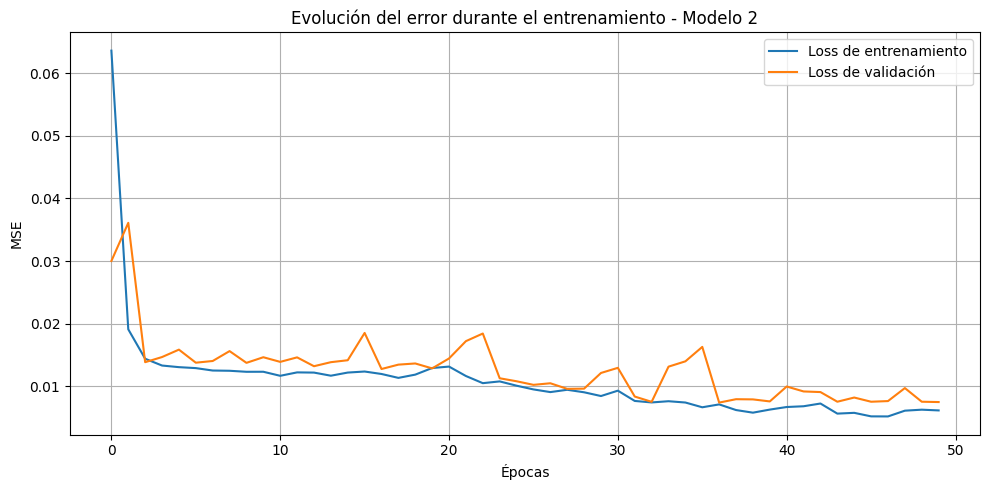

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(historial2.history['loss'], label='Loss de entrenamiento')
plt.plot(historial2.history['val_loss'], label='Loss de validación')
plt.title('Evolución del error durante el entrenamiento - Modelo 2')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Para el segundo modelo se optó por una arquitectura más profunda con Dropout y dos capas LSTM encadenas. Al compararlo con el primer modelo se obsra una pérdida de valifación ligeramente inferior en algunas etapas del entrenamiento.
Algo a notar es que la pérdida de validación se mantiene cerca a la entrenamiento, lo que sugiera eu el Dropout funciona como regulizadora.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred_1 = modelo1.predict(X_test)
y_pred_2 = modelo2.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_1_inv = scaler.inverse_transform(y_pred_1)
y_pred_2_inv = scaler.inverse_transform(y_pred_2)

def calcular_metricas(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    return rmse, mae

rmse_1, mae_1 = calcular_metricas(y_test_inv, y_pred_1_inv)
rmse_2, mae_2 = calcular_metricas(y_test_inv, y_pred_2_inv)

print(f"Modelo 1 - RMSE: {rmse_1:.4f} | MAE: {mae_1:.4f}")
print(f"Modelo 2 - RMSE: {rmse_2:.4f} | MAE: {mae_2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002B7E6BE5760> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
Modelo 1 - RMSE: 0.1183 | MAE: 0.0993
Modelo 2 - RMSE: 0.0981 | MAE: 0.0748


Al comparar las métricas de ambos modelos: RMSE y MAE, se observa como el segundo modelo tiene valores más bajos en comparación al primero, lo cual se traduce en un mejor rendimiento.  
Este segundo modelos posee una arquitectura más robusta al contar con dos capas LSTM y una regularización con Dropout, gracias a estas mejoras el modelo pudo capturar de manera más efectiva las dinámicas temporales de la serie. Esto se puede observar de manera gráfica con las dos figruas anteriormente mostradas.

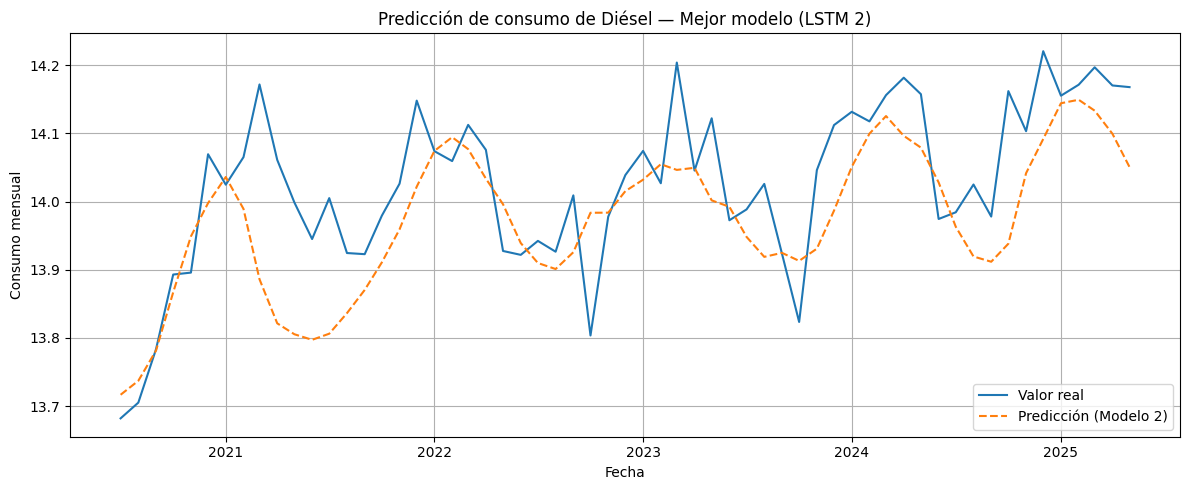

In [ ]:
fechas_test = serie.index[-len(y_test):]
fechas_test = pd.to_datetime(fechas_test)

fechas_test = pd.to_datetime(fechas_test)

import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(fechas_test, y_test_inv, label='Valor real')
plt.plot(fechas_test, y_pred_2_inv, label='Predicción (Modelo 2)', linestyle='--')

plt.title('Predicción de consumo de Diésel — Mejor modelo (LSTM 2)')
plt.xlabel('Fecha')
plt.ylabel('Consumo mensual')
plt.legend()
plt.grid(True)

# Mostrar una etiqueta por año
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Al observar de manera gráfica el rendimiento del modelo podemos observar como logra adaptarse correctamente a la tendencia, pero con un alto margen de mejora ya que generaliza de más creando predicciones que pueden llegar a ser ligeramente bagas.

## Compración con modelos del laboratorio anterior

La comparación de los modelos se hizo a partir de dos métricas principales: el RMSE (Root Mean Squared Error) y la MAE (Mean Absolute Error) que permiten medir la precisión de las predicciones de manera absoluta. Se consideró la capacidad del modelo para captar los patrones de tendencia, estacionalidad y cambios drásticos. Conestas consideraciones el modelo Prophet entrenado sobre la serie de consumo de diesel obtuvo el RMSE de aproximadamente 95,066 mientras que el LSTM deep learning obtuvo el RMSE de 98,100. Si bien ambos modelos fueron similares en desempeño, Prophet fue mejor entrenado en la captura de la estacionalidad anual y en la producción de predicciones más estables y explicable, mientras que el modelo LSTM mostró un buen desempeño en la captura de patrones no lineales aunque su predicción tiende a suavizar fluctaciones. Basandonos en estas métricas, es posible concluir que el modelo Prophet fue el mejor modelo para la serie de consumo de diesel, aunque el modelo LSTM deep learning representa una alternativa competitiva que (probablemente) con un mejor tuneo de parámetros o más capas podría igualar e incluso superar al Prophet.